In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import PIL
from PIL import Image

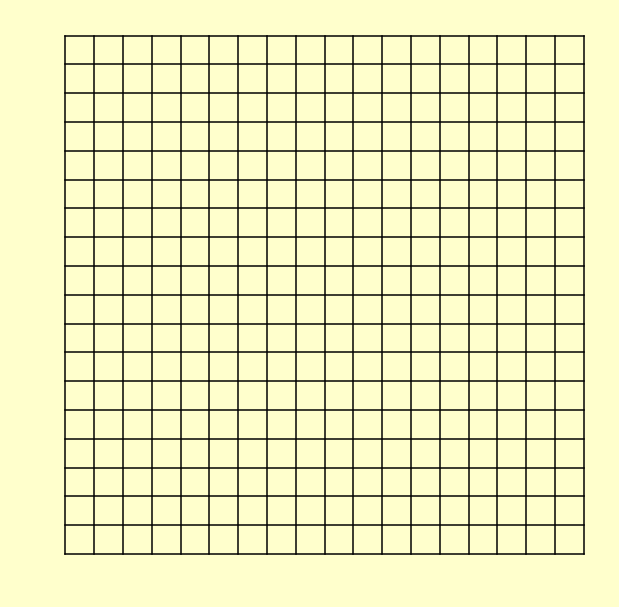

In [3]:
def drawBoard(positions):
    # create a 8" x 8" board
    fig = plt.figure(figsize=[8,8])
    fig.patch.set_facecolor((1,1,.8))

    ax = fig.add_subplot(111)

    # draw the grid
    for x in range(19):
        ax.plot([x, x], [0,18], 'k')
    for y in range(19):
        ax.plot([0, 18], [y,y], 'k')

    # scale the axis area to fill the whole figure
    ax.set_position([0,0,1,1])

    # get rid of axes and everything (the figure background will show through)
    ax.set_axis_off()

    # scale the plot area conveniently (the board is in 0,0..18,18)
    ax.set_xlim(-1,19)
    ax.set_ylim(-1,19)
    
    for pos in positions:
        s1, = ax.plot(pos[0],pos[1],'o',markersize=30, markeredgecolor=(0,0,0), markerfacecolor=pos[2], markeredgewidth=2)

drawBoard([])

In [4]:
import numpy as np
def draw_line(img, x1, y1, x2, y2):
    cv2.line(img,(x1,y1),(x2,y2),(0,0,255),2)

def draw_intersection_points(img, intersections):
    for isec_line in intersections:
        isec = isec_line[0]
        x = isec[0]
        y = isec[1]

        try:
            cv2.circle(img,(x,y),15, (0,0,255), -1)
        except:
            pass

def find_intersection(line1, line2):
    rho1, theta1 = line1
    rho2, theta2 = line2
    A = np.array([
        [np.cos(theta1), np.sin(theta1)],
        [np.cos(theta2), np.sin(theta2)]
    ])
    b = np.array([[rho1], [rho2]])
    x0, y0 = np.linalg.solve(A, b)
    x0, y0 = int(np.round(x0)), int(np.round(y0))
    return [[x0, y0]]


def segmented_intersections(lines):
    intersections = []
    for i, group in enumerate(lines[:-1]):
        for next_group in lines[i+1:]:
            for line1 in group:
                for line2 in next_group:
                    try:
                        intersections.append(find_intersection(line1, line2)) 
                    except:
                        pass

    return intersections


White count 16 Black count 15


True

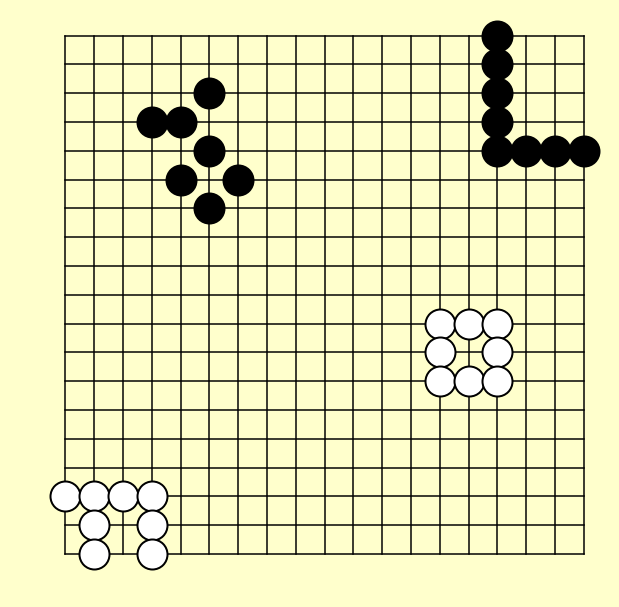

In [5]:
img = cv2.imread('data/go/board.png')
#img = cv2.imread('data/go/random-board.JPG')


#im = Image.open("data/go/IMG_3600.JPG")
#img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img = cv2.GaussianBlur(img, (7, 7), 3)

gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

edges = cv2.Canny(gray,50,150,apertureSize = 3)
#edges = cv2.dilate(edges, (7,7))
cv2.imwrite('data/go/out/canny.jpg',edges)
    

beta = 2
alfa = 150
lines = cv2.HoughLines(edges,1,np.pi/360*2,200)
bottomEdge = [-1000, -1000]
topEdge = [1000, 10000]
leftEdge = [1000, 1000]
rightEdge  = [-1000, -10000]

for line in lines:
    for rho, theta in line:
        a = np.cos(theta)
        b = np.sin(theta)
        x0 = a*rho
        y0 = b*rho

        x1 = int(x0 + 1000*(-b))
        y1 = int(y0 + 1000*(a))
        x2 = int(x0 - 1000*(-b))
        y2 = int(y0 - 1000*(a))
        
        # Use k-means instead?
        if theta > np.pi * 80/180 and theta<np.pi * 100 / 180:
            # Vertical
            if y0 < topEdge[1]:
                topEdge= [x0, y0, x1, y1, x2, y2, [rho, theta]]
            if y0 > bottomEdge[1]:
                bottomEdge = [x0, y0, x1, y1, x2, y2, [rho, theta]]
        elif theta < np.pi * 10/180 or  theta>np.pi * 170 / 180:
            # Horizontal
            if x0 > rightEdge[0]:
                rightEdge = [x0, y0, x1, y1, x2, y2, [rho, theta]]
            if x0 < leftEdge[0]:
                leftEdge = [x0, y0, x1, y1, x2, y2, [rho, theta]]


intersections = segmented_intersections([bottomEdge[6:], topEdge[6:], rightEdge[6:], leftEdge[6:]])
#top_intersections = segmented_intersections([topEdge[6:], leftEdge[6:]])
#draw_intersection_points(img, top_intersections)
#bottom_intersections = segmented_intersections([bottomEdge[6:], leftEdge[6:]])

center_points = intersections[1:5]

#draw_intersection_points(img, center_points)

cv2.imwrite('data/go/out/houghlines3.jpg',img)

pts1 = np.float32(center_points)
pts2 = np.float32([[300,300],[0,300],[300,0],[0,0]])
M = cv2.getPerspectiveTransform(pts1,pts2)
dst = cv2.warpPerspective(img,M,(300,300))

cur_y = 0
cur_x = 0

board_height = 310
board_width = 300
square_height = board_height / 19

area = (280, 0, 15, 15)
y = 270
x = 0
h = 7
w = 8
crop_img = dst[y:y+h, x:x+w]
cv2.imwrite('data/go/out/crop.jpg',crop_img)


import os
for file in os.listdir('data/go/out'):
    if file.endswith('.jpg'):
        os.remove('data/go/out/{}'.format(file)) 
        
white_count = 0
black_count = 0


positions = []
for sqx in range(19):
    cur_y = 0
    for sqi in range(19):
        #cv2.rectangle(dst,(cur_x,int(cur_y)),(int(cur_x+board_width),int(cur_y+square_height)),(0,255,0),3)
        x = round(cur_x)
        y = round(cur_y)
        crop_img = dst[y:y+h, x:x+w]
        crop_img = cv2.resize(crop_img,(100,100))
        crop_img = cv2.GaussianBlur(crop_img, (5, 5), 3)
        #crop_img = cv2.cvtColor(crop_img,cv2.COLOR_BGR2GRAY)
        #crop_img = cv2.Canny(crop_img,50,150,apertureSize = 3)
        im = Image.fromarray(crop_img)
        
        extrema = im.convert("L").getextrema()
        
        # convert to np.float32
        Z = np.float32(im.convert("L"))

        criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 1.0)
        flags = cv2.KMEANS_RANDOM_CENTERS
        ret,label,center = cv2.kmeans(Z, 3, None, criteria, 10, flags)
        
        mean = center.mean()
        #extrema = eim.convert("L").getextrema()
        #print(extrema)
        
        #value = sum(extrema)/len(extrema)
        #print(sqx, sqi, mean)
        if mean > 170:
            white_count = white_count + 1
            cv2.imwrite('data/go/out/crop_{}_{}.jpg'.format(sqx, sqi),crop_img)
            positions.append([sqx, 18-sqi,'white'])
        if mean < 60:
            black_count = black_count + 1
            cv2.imwrite('data/go/out/crop_{}_{}.jpg'.format(sqx, sqi),crop_img)
            positions.append([sqx, 18-sqi,'black'])

        cur_y = cur_y + square_height
    cur_x = cur_x + square_height
    
drawBoard(positions)
print("White count {} Black count {}".format(white_count, black_count))
cv2.imwrite('data/go/out/houghlines3.jpg',dst)



In [215]:

print("Lines done")
intersections = segmented_intersections(lines)
print("intersections done")

draw_intersection_points(img, intersections)
cv2.imwrite('data/go/out/houghlines3.jpg',img)


Lines done
intersections done


True

True

True